<a href="https://colab.research.google.com/github/erikaminarikova/Ordinal_Sums/blob/main/Example_5_learning_parameters_for_ordinal_sums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pygad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import statistics
import pygad
import numpy
import ast
import time
from sklearn.metrics import mean_squared_error
import math

In [4]:
#ordina sums functions

# defining the generic functions for individual classes
def yes_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
    return 1-max(0.0, (((1-x) ** kappa) + ((1-y) ** kappa) - ((1-a) ** kappa))) ** (1 / kappa)

def no_function(x: float, y: float, a: float, kappa: float, lam: float, gamma: float = 1) -> float:
        return max(0.0, ((x ** lam) + (y ** lam) - (a ** lam))) ** (1 / lam)

def maybe_function(x: float, y: float, a:float, kappa: float, lam: float, gamma: float = 1) -> float:
    if gamma == 0:
            # r = 0 means we use the geometric mean
        return 0
    elif gamma < 0:
            # r < 0 means we handle cases where x or y are 0
        if x == 0 or y == 0:
            return 0
        else:
                value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    else:
            value = gamma*1/a*x*y+(1-gamma)*(1-1/(1-a)*(1-x)*(1-y))

    return statistics.median([0, 1, value])

# defining function for classification: deviding values according thir value to which fuction we use
def classification(x: float, y: float, a: float, kappa: float, lam: float, gamma: float) -> float:
    if x<a and y<a:
        value = no_function(x,y,a,1,lam,1)
    elif x>a and y>a:
        value = yes_function(x,y,a,kappa,1,1)
    else:
        value = maybe_function(x,y,a,1,1,gamma)
    return round(value,4)

In [5]:
#alg for learning parameters in ordinal sums functions
def calculate_param_using_gen_alg(data:[] = [], number_of_attr = 0):
    #preparing input-output data
    df = data
    columns=len(df.columns)

    def fitness_func(ga_instance, solution, solution_idx):
        param = numpy.array(solution)
        df['value']=df.apply(lambda row: abs(row[0]-param[4]), axis =1)
        # parameters for attributes
        i=5
        j=0
        while j < columns-2:
            df['value']=df.apply(lambda row: classification(row['value'], abs(row[j+1]-param[i]), param[0], param[1], param[2], param[3]),
                                                            axis = 1)
            i += 1
            j += 1
        df['error']=df.apply(lambda row: numpy.abs(row['value'] - row['target']), axis=1)
        fitness = 1.0 / sum(df['error'])
        return fitness

    fitness_function = fitness_func

    num_generations = 50
    num_parents_mating = 4

    sol_per_pop = 24
    num_genes = 4+number_of_attr #number of learnt (tuned) parameters

    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 1

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 10

    i=",[0,1]"
    gene_space = "[{'low': 0, 'high': 1},{'low': 0, 'high': 1},{'low': 0, 'high': 5},{'low': 0, 'high': 5}"+i*number_of_attr+"]"

    ga_instance = pygad.GA(num_generations=num_generations,
                            num_parents_mating=num_parents_mating,
                            fitness_func=fitness_function,
                            sol_per_pop=sol_per_pop,
                            num_genes=num_genes,
                            init_range_low=init_range_low,
                            init_range_high=init_range_high,
                            parent_selection_type=parent_selection_type,
                            keep_parents=keep_parents,
                            crossover_type=crossover_type,
                            mutation_type=mutation_type,
                            mutation_percent_genes=mutation_percent_genes,
                            gene_space=ast.literal_eval(gene_space))

    ga_instance.run()

    ga_instance.plot_fitness()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    filename = 'genetic'
    #ga_instance.save(filename=filename)

    solution_param= numpy.array(solution)
    df['calc_value']=df.apply(lambda row: abs(row[0]-solution_param[4]), axis = 1)
    columns=len(df.columns)
    j=0
    i=5
    while j < columns-5:
        df['calc_value']=df.apply(lambda row: classification(row['calc_value'], abs(row[j+1] - solution_param[i]), solution_param[0], solution_param[1], solution_param[2], solution_param[3]),
                                                        axis = 1)
        i += 1
        j += 1

    merge_data = df
    #merge_data.to_csv("data/output.csv")
    mean_error = (sum(merge_data['error'])) / len(merge_data)
    kappa_result = solution_param[1]
    lam_result = solution_param[2]
    gamma_result = solution_param[3]
    a_result = solution_param[0]
    return merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, solution_param, solution_fitness, solution_idx



In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Fuction to despay relevant results
def show_results(data, mean_error, gamma_result, lam_result, kappa_result, a_result):
    # calculate the mean squared error
    target_values = data[['target']].values
    value = data[['calc_value']].values
    MSE = mean_squared_error(target_values, value)
    RMSE = math.sqrt(MSE)
    # print the results
    print('Results:')
    if all(col in data.columns for col in ['value','error']):
      print(data.drop(columns=['value','error']))
    else:
      print(data)
    #print('mean error: ', mean_error)
    print('\u03B3 = ', round(gamma_result, 4))
    print('\u03BB = ', round(lam_result, 4))
    print('\u03BA = ', round(kappa_result, 4))
    print('a = ', round(a_result, 4))
    print('Mean squared error = ', round(MSE, 4))
    print('Root Mean Square Error = ', round(RMSE, 4))

In [8]:
def print_attr_coef(sol_param):
  coeficients = []
  for i in sol_param:
    if i == 1:
      pom = '1-decreasing'
      coeficients.append(pom)
    elif i == 0:
      pom = '0-increasing'
      coeficients.append(pom)

  name_columns = merge_data.drop(columns=['target', 'value','error', 'calc_value']).columns

  merge_list = name_columns + [': '] + coeficients
  for list in coeficients:
    print(list)

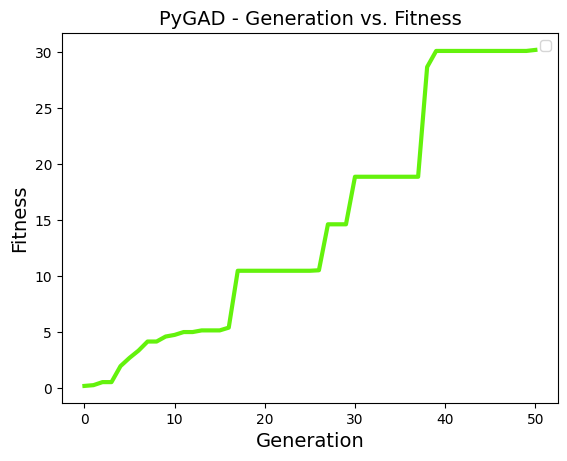

Results:
       x     y    target  calc_value
0   0.00  0.00  0.000000      0.0000
1   0.25  0.23  0.111831      0.1124
2   0.25  0.35  0.172792      0.1710
3   0.40  0.40  0.319195      0.3127
4   0.42  0.96  0.931520      0.9278
5   0.00  0.50  0.000000      0.0000
6   0.80  0.20  0.626000      0.6184
7   0.00  1.00  0.850000      0.8500
8   1.00  0.00  0.850000      0.8500
9   0.02  0.98  0.822560      0.8217
10  0.80  0.55  0.820889      0.8162
11  0.80  0.70  0.882877      0.8792
12  0.80  0.80  0.923444      0.9206
13  0.96  0.69  0.976766      0.9758
14  1.00  1.00  1.000000      1.0000
γ =  0.15
λ =  0.0002
κ =  0.0385
a =  0.5117
Mean squared error =  0.0
Root Mean Square Error =  0.0033
0-increasing
0-increasing
Parameters of the best solution : 0
Fitness value of the best solution = 30.10834155516853
Execution time [s]:  3.544008493423462


In [9]:
start_time = time.time()
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/learning_output_strict.csv', sep=';')
data=df

merge_data, mean_error, kappa_result, lam_result, gamma_result, a_result, sol_param, solution_fitness, solution_idx = calculate_param_using_gen_alg(data,2)

show_results(merge_data, mean_error, gamma_result, lam_result, kappa_result, a_result)
print_attr_coef(sol_param)
print("Parameters of the best solution : {solution_idx}".format(solution_idx=solution_idx))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

print('Execution time [s]: ', time.time()-start_time)


In [ ]:
merge_data

,x,y,target,value,error,calc_value
0,0.00,0.00,0.000000,1.0000,1.000000,0.0000
1,0.25,0.23,0.111831,0.4304,0.318569,0.1096
2,0.25,0.35,0.172792,0.5236,0.350808,0.1675
3,0.40,0.40,0.319195,0.6575,0.338305,0.3071
4,0.42,0.96,0.931520,0.9851,0.053580,0.9261
5,0.00,0.50,0.000000,1.0000,1.000000,0.0000
6,0.80,0.20,0.626000,0.8514,0.225400,0.6146
7,0.00,1.00,0.850000,1.0000,0.150000,0.8558
8,1.00,0.00,0.850000,1.0000,0.150000,0.8558
9,0.02,0.98,0.822560,0.9808,0.158240,0.8263
